## Customer Churn Prediction

In this project, the data will be used to predict whether a customer of the bank will churn. If a customer churns, it means they left the bank and took their business elsewhere. By predicting which customers are likely to churn, we can take measures to retain them before they do. Our target variable is the column called 'Exited'. it's 0 if the customer did not leave and 1 if the customer left.

In [1]:
import pandas as pd
import numpy as np

In [2]:
df_original = pd.read_csv('Churn_Modelling.csv')
df_original.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


From this table, we can confirm that the data has 14 features and 10,000 observations. We also know that nine features are integers, two are floats, and three are strings. Finally, we can tell that there are no null values because there are 10,000 observations, and each column has 10,000 non-null values.

In [4]:
# calculate average balance of costumers who churned

avg_churned_bal = df_original[df_original['Exited']==1]['Balance'].mean()
avg_churned_bal

91108.53933726063

This shows that the customers who churned each took with them €91,108.54, on average. That's a lot of money! This represents the average cost of the model predicting a false negative.

What's the cost of predicting a false positive? Well, it's the cost of whatever the incentive might be to convince someone to stay with the bank when they were going to stay regardless of whether or not they were incentived. We don't have a number for this, and even if it's probably less than €91,108.54, it still could be thousands of Euros per customer in lost revenue, depending on the details of the incentive.

Since correctly identifying customers who will churn is potentially very valuable, we *could* select recall as our most important metric. This might be a perfectly valid approach, depending on the specifics of the campaign. But this could also be problematic. After all, if we select a model based solely on recall, we could select a very biased model that predicts everyone to churn, but then 8,000 people would be given incentives needlessly.  

Since we don't know the exact cost of predicting a false negative, we'll make an assumption for this exercise. We'll assume that a metric that balances precision and recall is best. The metric that helps us achieve this balance is _F1 score_, which is defined as the harmonic mean of precision and recall. 

$${F_{1}} = 2 \cdot \frac{precision \cdot  recall}{precision + recall}$$  
</br>

Now that we've decided on an evaluation metric, let's prepare the data for modeling.

### Feature Engineering

notice that the first column is called RowNumber, and it just enumerates the rows. We should drop this feature, because row number shouldn't have any correlation with whether or not a customer churned.
The same is true for CustomerID, which appears to be a number assigned to the customer for administrative purposes, and Surname, which is the customer's last name. Since these cannot be expected to have any influence over the target variable, we can remove them from the modeling dataset.

Finally, for ethical reasons, we should remove the Gender column. The reason for doing this is that we don't want our model-making predictions (and therefore, offering promotions/financial incentives) based on a person's gender.

In [5]:
# drop unnecessary columns:

churn_df = df_original.drop(['RowNumber', 'CustomerId', 'Surname', 'Gender'], axis = 1)

In [6]:
churn_df.head()

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,41,1,83807.86,1,0,1,112542.58,0
2,502,France,42,8,159660.80,3,1,0,113931.57,1
3,699,France,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,43,2,125510.82,1,1,1,79084.10,0


Let's create a **Loyalty** feature that represents the percentage of each customer's life that they were customers. We can do this by dividing Tenure by Age:

Loyalty = Tenure/Age

In [7]:
# Create a new feature:

churn_df['Loyalty'] = churn_df['Tenure'] / churn_df['Age']
churn_df.head()

,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Loyalty
0,619,France,42,2,0.00,1,1,1,101348.88,1,0.047619
1,608,Spain,41,1,83807.86,1,0,1,112542.58,0,0.024390
2,502,France,42,8,159660.80,3,1,0,113931.57,1,0.190476
3,699,France,39,1,0.00,2,0,0,93826.63,0,0.025641
4,850,Spain,43,2,125510.82,1,1,1,79084.10,0,0.046512


### Feature Transformation

The models we will be building with this data are all classification models, and classification models generally need categorical variables to be encoded. Our dataset has one categorical feature: Geography. Let's check how many categories appear in the data for this feature.

In [8]:
# print unique values of Geography col

churn_df['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

There are three unique values: France, Spain, and Germany. Encode this data so it can be represented using Boolean features. We will use a pandas function called pd.get_dummies() to do this.

When we call pd.get_dummies() on this feature, it will replace the Geography column with three new Boolean columns--one for each possible category contained in the column being dummied.

When we specify drop_first=True in the function call, it means that instead of replacing Geography with three new columns, it will instead replace it with two columns. We can do this because no information is lost from this, but the dataset is shorter and simpler.

In this case, we end up with two new columns called Geography_Germany and Geography_Spain. We don't need a Geography_France column, because if a customer's values in Geography_Germany and Geography_Spain are both 0, we will know they are from France!

In [9]:
# Dummy encode categorical variables

churn_df = pd.get_dummies(churn_df, drop_first=True)
churn_df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Loyalty,Geography_Germany,Geography_Spain
0,619,42,2,0.00,1,1,1,101348.88,1,0.047619,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0.024390,0,1
2,502,42,8,159660.80,3,1,0,113931.57,1,0.190476,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0.025641,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0.046512,0,1


#### construct and test a Naive Bayes model with scikit-learn. 

This is a classification task, because we are trying to predict on a binary class. Naive Bayes often works well for this kind of task. In this case, if we wanted to build the best possible Naive Bayes model, we'd treat each variable according to their different types and distributions, and then combine each conditional probability to get the final prediction for each observation. We're going to use the `GaussianNB` classifier. This implementation assumes that all of your variables are continuous _and_ that they have a Gaussian (i.e., normal) distribution. Our data doesn't perfectly adhere to these assumptions, but a Gaussian model may still yield usable results, even with imperfect data.

In [10]:
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB

from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [11]:
churn_df = pd.read_csv('churn_df.csv')
churn_df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Loyalty,Geography_Germany,Geography_Spain
0,619,42,2,0.00,1,1,1,101348.88,1,0.047619,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0.024390,0,1
2,502,42,8,159660.80,3,1,0,113931.57,1,0.190476,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0.025641,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0.046512,0,1


#### Check the class balance

In [12]:
churn_df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

The class is split roughly 80/20. In other words, ~20% of the people in this dataset churned. This is an unbalanced dataset, but it's not extreme. 

### Drop dependent variables

Naive Bayes models operate best when there's conditional independence between the predictor variables. When we prepared our data, we engineered a feature called `Loyalty` by dividing `Tenure` by `Age`. Because this new feature is just the quotient of two existing variables, it's no longer conditionally independent. Therefore, we'll drop `Tenure` and `Age` to help adhere to the assumptions of our model.

In [13]:
churn_df = churn_df.drop(['Tenure', 'Age'], axis=1)
churn_df.head()

,CreditScore,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Loyalty,Geography_Germany,Geography_Spain
0,619,0.00,1,1,1,101348.88,1,0.047619,0,0
1,608,83807.86,1,0,1,112542.58,0,0.024390,0,1
2,502,159660.80,3,1,0,113931.57,1,0.190476,0,0
3,699,0.00,2,0,0,93826.63,0,0.025641,0,0
4,850,125510.82,1,1,1,79084.10,0,0.046512,0,1


### Split the data

I've prepared our data and I'm ready to model. There's one last step before I can begin. I must split the data into features and target variable, and into training data and test data. I do this using the `train_test_split()` function. I'll put 25% of the data into our test set, and use the remaining 75% to train the model.

I include the argument `stratify=y`. If the master data has a class split of 80/20, stratifying ensures that this proportion is maintained in both the training and test data. `=y` tells the function that it should use the class ratio found in the `y` variable.

The less data you have overall, and the greater your class imbalance, the more important it is to stratify when you split the data. If I didn’t stratify, then the function would split the data randomly, and I could get an unlucky split that doesn’t get any of the minority class in the test data, which means I wouldn’t be able to effectively evaluate my model. 


In [14]:
# define the y & X variable
y = churn_df['Exited']
X= churn_df.copy()
X = X.drop('Exited', axis=1)

# split into test and train sets
X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)


## Modeling
### 1. Unscaled data

I am finally ready to model! The modeling process will begin with fitting the model to the training data, and then using the model to make predictions on the test data.

In [15]:
# fit the model
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# get the predictions on test data
y_preds = gnb.predict(X_test)

Let's see how our model performs based on the evaluation metrics

In [16]:
print('Accuracy:', '%.3f' % accuracy_score(y_test, y_preds))
print('Precision:', '%.3f' % precision_score(y_test, y_preds))
print('Recall:', '%.3f' % recall_score(y_test, y_preds))
print('F1 Score:', '%.3f' % f1_score(y_test, y_preds))

Accuracy: 0.796
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


/home/sara/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Hmm… this isn’t very good. The precision, recall, and F1 scores are all zero. What’s going on? Well, let’s consider the precision formula: 
$$precision = \frac{\text{true positives}}{\text{false positives + true positives}}$$
  </br> 

There are two ways for the model to have a precision of zero. The first is if the numerator is zero, which would mean that my model didn’t predict any true positives. 

The second is if the denominator is also zero, which would mean that my model didn’t predict any positives at all. Dividing by zero results in an undefined value, but scikit-learn will return a value of zero in this case. 

If I call `np.unique()` on the model's predictions and it doesn't return an array containing `[0, 1]`, I'll know it's not predicticting any churned customers.

In [17]:
np.unique(y_preds)

array([0])

This confirms that the model predicted 0 (not churned) for every sample in the test data.

In [18]:
X.describe()

,CreditScore,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Loyalty,Geography_Germany,Geography_Spain
count,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.137936,0.250900,0.247700
std,96.653299,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.089506,0.433553,0.431698
min,350.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000,0.000000,0.000000
25%,584.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.064516,0.000000,0.000000
50%,652.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.129032,0.000000,0.000000
75%,718.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.200000,1.000000,0.000000
max,850.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,0.555556,1.000000,1.000000


Something that stands out is that the Loyalty variable I created is on a vastly different scale than some of the other variables I have, such as Balance or EstimatedSalary. The maximum value of Loyalty is 0.56, while the maximum for Balance is over 250,000—almost six orders of magnitude greater!

### 2. Scaled data

Some models require us to scale the data in order for them to operate as expected, others don't. Naive Bayes does not require data scaling. However, sometimes packages and libraries need to make assumptions and approximations in their calculations. I'm already breaking some of these assumptions by using the `GaussianNB` classifier on this dataset, and it may not be helping that some of our predictor variables are on very different scales. In general, scaling might not improve the model, but it probably won't make it worse. Let's try scaling our data.

I'll use a function called `MinMaxScaler`, which I'll import from the `sklearn.preprocessing` module. `MinMaxScaler` normalizes each column so every value falls in the range of [0, 1]. The column's maximum value would scale to 1, and its minimum value would scale to 0. Everything else would fall somewhere between. This is the formula:

$${x_{scaled}} = \frac{x - x_{min}}{x_{max} - x_{min}}$$ 

To use a scaler, we must fit it to the training data, and transform both the training data _and_ the test data using that same scaler. 

Let's apply this and retrain the model.

In [19]:
# import the scaler function
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

# fit the scaler to the training data
scaler.fit(X_train)

# scale the training data
X_train = scaler.transform(X_train)

# scale the test data
X_test = scaler.transform(X_test)

Now, I fit the model.

In [20]:
# fit the model
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# get the predictions on test data
y_preds = gnb.predict(X_test)

In [21]:
print('Accuracy:', '%.3f' % accuracy_score(y_test, y_preds))
print('Precision:', '%.3f' % precision_score(y_test, y_preds))
print('Recall:', '%.3f' % recall_score(y_test, y_preds))
print('F1 Score:', '%.3f' % f1_score(y_test, y_preds))

Accuracy: 0.810
Precision: 0.572
Recall: 0.261
F1 Score: 0.358


It works now!

### Evaluation
Let's examine more closely how our model classified the test data. I'll do this with a confusion matrix. A confusion matrix is a graphic that shows our models true and false positives, and true and false negatives. We can do this using the ConfusionMatrixDisplay and confusion_matrix functions that we imported.

Here's a helper function that will allow me to plot a confusion matrix for our model.

In [22]:
def conf_matrix_plot(model, x_data, y_data):
    '''
    Accepts as argument model object, X data (test or validate), and y data (test or validate). 
    Return a plot of confusion matrix for predictions on y data.
    ''' 
  
    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=model.classes_,
                                 )
  
    disp.plot(values_format='') # `values_format=''` suppresses scientific notation
    plt.show()

In [23]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Example: create a Naive Bayes model with scaled input
gnb_scaled = make_pipeline(StandardScaler(), GaussianNB())
gnb_scaled.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gaussiannb', GaussianNB(priors=None, var_smoothing=1e-09))],
         verbose=False)

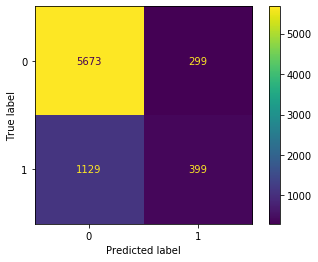

In [24]:
conf_matrix_plot(gnb_scaled, X_test, y_test)

## Decision Tree Model

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

# This function displays the splits of the tree
from sklearn.tree import plot_tree

In [26]:
# encoding

churn_df = pd.get_dummies(churn_df, drop_first = True)
churn_df.head()

,CreditScore,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Loyalty,Geography_Germany,Geography_Spain
0,619,0.00,1,1,1,101348.88,1,0.047619,0,0
1,608,83807.86,1,0,1,112542.58,0,0.024390,0,1
2,502,159660.80,3,1,0,113931.57,1,0.190476,0,0
3,699,0.00,2,0,0,93826.63,0,0.025641,0,0
4,850,125510.82,1,1,1,79084.10,0,0.046512,0,1


In [27]:
decision_tree = DecisionTreeClassifier(random_state=0)


# fit the data to training data
decision_tree.fit(X_train, y_train)


# make prediction on test data
dt_pred = decision_tree.predict(X_test)

In [28]:
# generate performance metrics

print("Accuracy:", "%.3f" % accuracy_score(y_test, dt_pred))
print("Precision:", "%.3f" % precision_score(y_test, dt_pred))
print("Recall:", "%.3f" % recall_score(y_test, dt_pred))
print("F1 Score:", "%.3f" % f1_score(y_test, dt_pred))

Accuracy: 0.764
Precision: 0.420
Recall: 0.420
F1 Score: 0.420


### Analysis of baseline model

#### Confusion matrix
Let's inspect the confusion matrix of our decision tree's prediction


In [29]:
def conf_matrix_plot(model, x_data, y_data):
    '''
    Accepts as argument model object, X data (test or validate), and y data (test or validate). 
    Returns a plot of confusion matrix for predictions on y data.
    ''' 
  
    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)
  
    disp.plot(values_format='')  # `values_format=''` suppresses scientific notation
    plt.show()

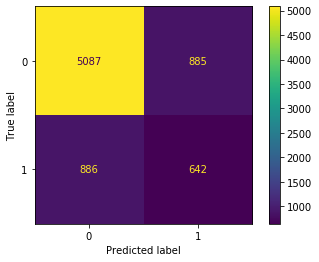

In [30]:
# generate CM

conf_matrix_plot(decision_tree, X_test, y_test)

Notice from this confusion matrix that the model correctly predicts many true negatives. Of course, this is to be expected, given that the dataset is imbalanced in favor of negatives. When the model makes an error, it appears slightly more likely to predict a false positive than a false negative, but it's generally balanced. This is reflected in the precision and recall scores both being very close to each other.

### Tune and Validate the Model

In [31]:
# import GridSearchCV

from sklearn.model_selection import GridSearchCV

In [32]:
# 1. assign a dictionary of hyperparameters to search over
tree_para = {'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50],
             'min_samples_leaf': [2, 5, 10, 20, 50]}

In [33]:
# 2. Create a dictionary of scoring metrics
scoring = {'accuracy', 'precision', 'recall', 'f1'}

In [34]:
# 3. Instantiate the classifier
tuned_decision_tree = DecisionTreeClassifier(random_state = 42)

In [35]:
# 4. Instantiate the GridSearchCV
clf = GridSearchCV(tuned_decision_tree,
                  tree_para,
                  scoring = scoring,
                  cv = 5,
                  refit = "f1")
# 5. fit the model
clf.fit(X_train, y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort='deprecated',
                                              random_state=42,
                                              splitter='best'),
             iid='deprecated', n_jobs=None,
             param_grid={'max_depth': [4, 5, 6, 7, 8, 9, 10, 11, 12, 15, 20, 30,

Now that the model is fit and cross-validated, we can use the best_estimator_ attribute to inspect the hyperparameter values that yielded the highest F1 score during cross-validation.

In [36]:
# Examine the best model from GridSearch
clf.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=7, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=20, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='best')

The best_score_ attribute returns the best average F1 score across the different folds among all the combinations of hyperparameters.

In [37]:
print("Best Avg. Validation Score: ", "%.4f" % clf.best_score_)

Best Avg. Validation Score:  0.4924


Although the F1 score of 0.492 is significantly better than the baseline model's F1 score of 0.420, it's not a fair comparison, because the baseline model was scored on the test data and the tuned model was scored against validation folds that came from the training data.

Recall that when we ran our grid search, we specified that we also wanted to capture precision, recall, and accuracy. The reason for doing this is that it's difficult to interpret an F1 score. These other metrics are much more directly interpretable, so they're worth knowing.

The following cell defines a helper function that extracts these scores from the fit GridSearchCV object and returns a pandas dataframe with all four scores from the model with the best average F1 score during validation. This function will help us later when we want to add the results of other models to the table.

In [38]:
def make_results(model_name, model_object):
    '''
    Accepts as arguments a model name (your choice - string) and
    a fit GridSearchCV model object.
  
    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean F1 score across all validation folds.  
    '''

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(mean f1 score)
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
  
    # Create table of results
    table = pd.DataFrame({'Model': [model_name],
                        'F1': [f1],
                        'Recall': [recall],
                        'Precision': [precision],
                        'Accuracy': [accuracy]
                         }
                        )
  
    return table

In [39]:
# Call the function on our model
result_table = make_results("Tuned Decison Tree", clf)

In [40]:
# We can save these results and open them in another notebook if we want to add to them. 
# We'll save as a .csv file using to_csv().
result_table.to_csv("Results.csv")

In [41]:
result_table

,Model,F1,Recall,Precision,Accuracy
0,Tuned Decison Tree,0.492407,0.400718,0.65988,0.8336


### Calculate Feature Importance

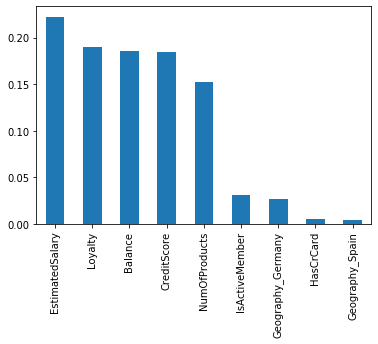

In [42]:
importances = decision_tree.feature_importances_
forest_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax);

## Random Forest Model 

In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# This lets us see all of the columns, preventing Jupyter from redacting them.
pd.set_option('display.max_columns', None)

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay

from sklearn.ensemble import RandomForestClassifier

# this module lets us save our models once we fit them.
import pickle

In [44]:
file = 'Churn_Modelling.csv'
df_original = pd.read_csv(file)
churn_df = df_original.drop(['RowNumber', 'CustomerId', 'Surname', 'Gender'], axis=1)
# Dummy encode
churn_df2 = pd.get_dummies(churn_df, drop_first='True')
churn_df2.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain
0,619,42,2,0.00,1,1,1,101348.88,1,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,1
2,502,42,8,159660.80,3,1,0,113931.57,1,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,1


In [45]:
# define the y variable

y = churn_df2['Exited']

# define x

X = churn_df2.copy()
X = X.drop('Exited', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

### Cross-validated hyperparameter tuning

In [46]:
%%time

rf = RandomForestClassifier(random_state=0)

cv_params = {'max_depth': [2,3,4,5, None],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'max_features': [2,3,4],
             'n_estimators': [75, 100, 125, 150]
            }
scoring = {'accuracy', 'precision', 'recall', 'f1'}

rf_cv = GridSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='f1')

rf_cv.fit(X_train, y_train)

CPU times: user 27min 49s, sys: 18 s, total: 28min 7s
Wall time: 28min 19s


GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False, random_state=0,
                                   

In [47]:
# define a path to the folder where you want to save the model

path = 'C:\Advanced Google Data Science\Customer Churn'


In [48]:
# pickle the model
with open(path+'rf_cv_model.pickle', 'wb') as to_write:
    pickle.dump(rf_cv, to_write)

In [49]:
# read in pickled model
with open(path + 'rf_cv_model.pickle', 'rb') as to_read:
    rf_cv = pickle.load(to_read)

In [50]:
rf_cv.fit(X_train, y_train)
rf_cv.best_params_

{'max_depth': None,
 'max_features': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 125}

In [51]:
rf_cv.best_score_

0.580528563620339

In [52]:
def make_results(model_name, model_object):
    '''
    Accepts as arguments a model name (your choice - string) and
    a fit GridSearchCV model object.

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean F1 score across all validation folds.
    '''
    
    # get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)
    
    # isolate the row of the df with the max(mean f1 score) 
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]
    
    
    # extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
    
    #create table of results
    table = pd.DataFrame({'Model': [model_name],
                         'F1': [f1],
                         'Recall': [recall],
                         'Precision': [precision],
                         'Accuracy': [accuracy]
                         }
                        )
    return table

In [53]:
# make a result table for the rf_cv model using above function
rf_cv_results = make_results('Random Forest CV', rf_cv)
rf_cv_results

,Model,F1,Recall,Precision,Accuracy
0,Random Forest CV,0.580529,0.472517,0.756289,0.861333


In [54]:
# concatenate the random forst results to the master table
results = pd.concat([rf_cv_results, result_table])
results

,Model,F1,Recall,Precision,Accuracy
0,Random Forest CV,0.580529,0.472517,0.756289,0.861333
0,Tuned Decison Tree,0.492407,0.400718,0.659880,0.833600


## XGBoost Model

In [55]:
import pandas as pd
import numpy as np

from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay,RocCurveDisplay

import matplotlib.pyplot as plt
# This displays all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

# This module lets us save our models once we fit them.
import pickle

In [56]:
# define the y variable

y = churn_df2['Exited']

# defne X variables

X = churn_df2.copy()
X = X.drop('Exited', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=42)

## Modeling
### Cross-validated hyperparameter tuning

In [58]:
xgb = XGBClassifier(objective = 'binary:logistic', random_state=0)

cv_params = {'max_depth': [4,5,6,7,8],
            'min_child_weight': [1,2,3,4,5],
            'learning_rate': [0.1, 0.2, 0.3],
            'n_estimators': [75, 100, 125]
            }
scoring = {'accuracy', 'precision', 'recall', 'f1'}
xgb_cv = GridSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='f1')



In [59]:
%%time
xgb_cv.fit(X_train, y_train)

CPU times: user 1h 29min 6s, sys: 1min 33s, total: 1h 30min 39s
Wall time: 12min 36s


GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max...
                                     objective='binary:logistic',
                                     predictor=None, random_state=0,
                                     reg_alpha=None, ...),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.

### Pickle

In [60]:
path = 'C:\Advanced Google Data Science\Customer Churn'

In [61]:
# pickle the model

with open(path + 'xgb_cv_model.pickle', 'wb') as to_write:
    pickle.dump(xgb_cv, to_write)

In [62]:
# open pickled model
with open(path + 'xgb_cv_model.pickle', 'rb') as to_read:
    xgb_cv = pickle.load(to_read)

Let's check our model's score and compare it to our random forest's score on the same cross-validated train data.

In [68]:
def make_results(model_name, model_object):
    '''
    Accepts:
        - model_name (str): name of the model
        - model_object (GridSearchCV): a fit GridSearchCV model object

    Returns:
        - A pandas DataFrame with F1, Recall, Precision, and Accuracy scores
          for the best mean F1 across validation folds.
    '''
    
    # Get all the CV results
    cv_results = pd.DataFrame(model_object.cv_results_)
    
    # Find the row with the best mean F1 score
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]
    
    # Extract performance metrics
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy
    
    # Return results in a DataFrame
    table = pd.DataFrame({
        'Model': [model_name],
        'F1': [f1],
        'Recall': [recall],
        'Precision': [precision],
        'Accuracy': [accuracy]
    })
    
    return table


In [69]:
xgb_cv_results = make_results('XGBoost CV', xgb_cv)
xgb_cv_results

,Model,F1,Recall,Precision,Accuracy
0,XGBoost CV,0.583825,0.482342,0.744089,0.8604


In [71]:
# concatenate the random forst results to the master table
results = pd.concat([rf_cv_results, result_table, xgb_cv_results])
results

,Model,F1,Recall,Precision,Accuracy
0,Random Forest CV,0.580529,0.472517,0.756289,0.861333
0,Tuned Decison Tree,0.492407,0.400718,0.659880,0.833600
0,XGBoost CV,0.583825,0.482342,0.744089,0.860400


## Model Selection and Final Results
#### Prediction on the test data

I'm ready to select a champion model! Based on the above table, it's clear that the XGBoost model has the top F1 score on the validation data by a small margin.

Since I won't be building any more models, I use our champion model (XGBoost) to predict on the test data.

In [72]:
# Predict on the test data

xgb_cv_preds = xgb_cv.predict(X_test)
print('f1 score final XGB model:', f1_score(y_test, xgb_cv_preds))
print('Recall score final XGB model:', recall_score(y_test, xgb_cv_preds))
print('Precision score final XGB model:', precision_score(y_test, xgb_cv_preds))
print('Accuracy score final XGB model:', accuracy_score(y_test, xgb_cv_preds))

f1 score final XGB model: 0.6059171597633135
Recall score final XGB model: 0.5029469548133595
Precision score final XGB model: 0.7619047619047619
Accuracy score final XGB model: 0.8668


### Confusion Matrix

In [73]:
# create helper function to plot confusion matrix
def conf_matrix_plot(model, x_data, y_data):
    '''
    Accepts as argument model object, X data (test or validate), and y data (test or validate). 
    Returns a plot of confusion matrix for predictions on y data.
    ''' 
    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)
  
    disp.plot()
    plt.show()

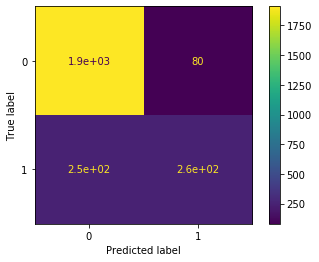

In [74]:
conf_matrix_plot(xgb_cv, X_test, y_test)

#### Result
From the 2,500 people in our test data, there are 509 customers who left the bank. Of those, our model captures 256. The confusion matrix indicates that, when the model makes an error, it’s usually a Type II error—it gives a false negative by failing to predict that a customer will leave. On the other hand, it makes far fewer Type I errors, which are false positives.

Ultimately, whether these results are acceptable depends on the costs of the measures taken to prevent a customer from leaving versus the value of retaining them. In this case, bank leaders may decide that they’d rather have more true positives, even if it means also capturing significantly more false positives. If so, perhaps optimizing the models based on their F1 scores is insufficient. Maybe we’d prioritize a different evaluation metric.

One way to modify the decision-making without retraining the model is to adjust the threshold at which the model predicts a positive response. In other words, the model determines a probability that a given customer will churn. By default, if that probability is ≥ 0.50, then the model will label that customer as churned. Probabilities of < 0.50 would designate a non-responder. But it's possible to adjust this decision threshold. For instance, if we set the threshold to 0.25, then the model would label customers with predicted probabilities ≥ 0.25 as churned, and those with probabilities < 0.25 as not churned. This would increase the recall of the model, but decrease the accuracy.

In any case, what is certain is that our model helps the bank. Consider the results if decision-makers had done nothing. In that case, they’d expect to lose 509 customers. Alternatively, they could give everybody an incentive to stay. That would cost the bank for each of the 2,500 customers in our test set. Finally, the bank could give incentives at random—say, by flipping a coin. Doing this would incentivize about the same number of true responders as our model selects. But the bank would lose a lot of money offering the incentives to people who aren’t likely to leave, and our model is very good at identifying these customers.

### Feature Importance


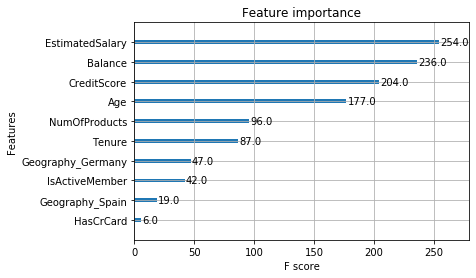

In [78]:
plot_importance(xgb_cv.best_estimator_);

This tells us that the four most important features used by our model were EstimatedSalary, Balance, CreditScore, and Age. This is very useful information. In a full project, we'd go back and examine these features very closely to understand how and why they are affecting churn.